# TP 2 - Bandit Algorithms (November 23)

Name: Diego Andres Torres Guarin

In this assignement, we will focus on the MultiArmed Bandits problem.
You will implement:


- Deterministic policy UCB1 normal  https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf or Chapter 7 of Bandit Algorithms

- Boltzmann Exploration (Softmax) https://www.cs.mcgill.ca/~vkules/bandits.pdf

- KL-UCB https://hal.archives-ouvertes.fr/hal-00738209v2 or Chapter 10.2 of Bandits Algorithm

- Best Empirical Sampled Average (BESA) https://hal.archives-ouvertes.fr/hal-01025651v1/document 

- Thompson Sampling Agent  https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf, https://en.wikipedia.org/wiki/Thompson_sampling or Chapter 35 and 36 of Bandits Algorithms


![image not found:](multiarmedbandit.jpg "Bandits")

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A small paragraph with an analysis of the behavior of the agent and your understanding of the algorithm
* Answering this question -> for each implemented agent, give 1 pros and 1 cons ?

Send this notebook  to cyriaque.rousselot@inria.fr before next course.

Good Luck !

## Example : Random Agent and Epsilon Greedy Agent


In `choose`, prescribe how the agent selects its
actions (interact must return an action, that is
an index in `[0, ..., n_a]`).

In `update`, implement how the agent updates
its knowledge, using the newly observed `action` and `reward`.

In [1]:
import runner, environment
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

### Agent Definition

In [2]:
class RandomAgent:
    def __init__(self, n_a):
        self.n_a = n_a  # number of possible actions
        """Init a new agent.
        """

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        return np.random.randint(0, self.n_a)

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        pass

### Agent Evaluation

There exists two classes from the ```environment``` package, ```environment.EasyEnvironment``` and ```environment.HardEnvironement```. Try the agents on both for your analysis.

The Environment Class takes two arguments: ```n_a``` the number of actions and ```variability```, a parameter between 0 and 1 that influence the spreading of distribution of the reward between bandits.

Simulation step 1:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 2:
 ->            action: 6
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 3:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 4:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 9
 ->            reward: 1
 -> cumulative reward: 3.0
Simulation step 7:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 3.0
Simulation step 8:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 3.0
Simulation step 9:
 ->            action: 2
 ->            reward: 1
 -> cumulative reward: 4.0
Simulation step 10:
 ->            action: 9
 ->            reward: 1
 -> cumulative reward: 5.0
Simulation step 11:
 ->            acti

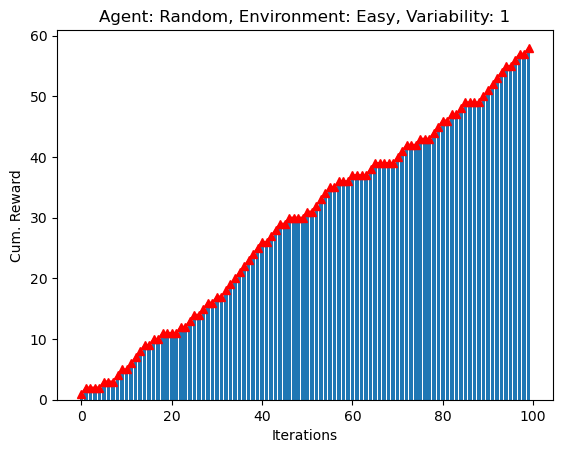

In [138]:
# Looping on a single environement and a single agent
niter = 100
n_actions = 10
my_agent = RandomAgent(n_actions)
my_env = environment.EasyEnvironment(n_actions, variability=1)
my_runner = runner.Runner(
    my_env, my_agent, verbose=True
)  # The verbose parameter allows displaying every step
final_reward, list_cumul = my_runner.loop(niter)
print("Obtained a final reward of {}".format(final_reward))

plt.bar(range(niter), list_cumul)
plt.plot(list_cumul, marker="^", color="red")
plt.xlabel("Iterations")
plt.ylabel("Cum. Reward")
plt.title("Agent: Random, Environment: Easy, Variability: 1")
plt.show()

In [139]:
# Running a batched simulation with n_agents agents in parallel
niter = 1000
n_agents = 10
n_actions = 10
variability = 1
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    RandomAgent,
    n_agents,
    n_actions,
    variability=variability,
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("Random Agent obtained a final average reward of {}".format(final_reward_rd))

Random Agent obtained a final average reward of 502.3000000000003


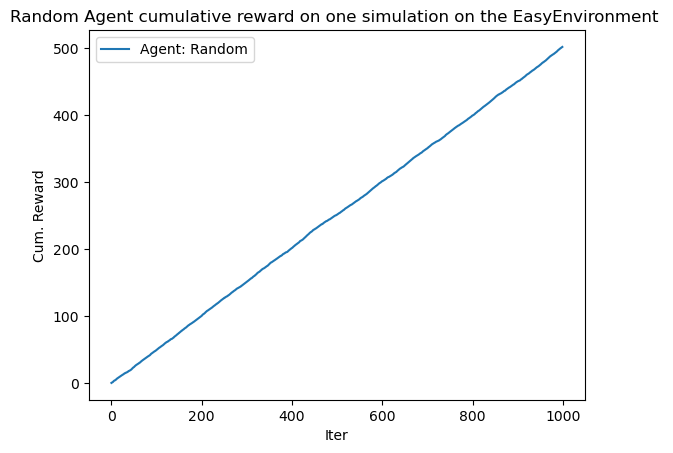

In [140]:
plt.plot(list_cumul_rd, label="Agent: Random")
plt.xlabel("Iter")
plt.ylabel("Cum. Reward")
plt.title("Random Agent cumulative reward on one simulation on the EasyEnvironment ")
plt.legend()
plt.show()

In [174]:
def plot_single_run(agent):
    niter = 100
    n_actions = 10
    np.random.seed(1)
    env = environment.EasyEnvironment(n_actions, variability=1)
    print(*env.ps, sep='\n')
    my_runner = runner.Runner(
        env, agent, verbose=True
    )  # The verbose parameter allows displaying every step
    final_reward, list_cumul = my_runner.loop(niter)
    print("Obtained a final reward of {}".format(final_reward))


    plt.bar(range(niter), list_cumul)
    plt.plot(list_cumul, marker="^", color="red")
    plt.xlabel("Iterations")
    plt.ylabel("Cum. Reward")
    plt.title(f"Agent: {agent.__class__.__name__}, Environment: {env.__class__.__name__}, Variability: 1")
    plt.show()

In [157]:
def evaluate_batch(agent_class, environment_class, param_values):
    np.random.seed(10)
    name, param_values = param_values
    cum_rewards = []
    for value in param_values:
        niter = 1000
        n_agents = 15
        n_actions = 10
        variability = 1
        my_runner = runner.BatchRunner(
            environment_class,
            agent_class,
            n_agents,
            n_actions,
            variability=variability,
            verbose=False,
            **{name: value},
        )
        final_reward_rd, list_cumul_rd = my_runner.loop(niter)
        print(f"{agent_class.__name__} {name}={value} obtained a final average reward of {final_reward_rd}")
        cum_rewards.append(list_cumul_rd)
    return cum_rewards

In [158]:
def plot_cum_rewards(cum_rewards, param_values, title):
    name, param_values = param_values
    for i, cum_reward in enumerate(cum_rewards):
        plt.plot(cum_reward, label=f"{name}: {param_values[i]}")
    plt.xlabel("Iter")
    plt.ylabel("Cum. Reward")
    plt.title(title)
    plt.legend()
    plt.show()

In [160]:
def plot_final_rewards(cum_rewards, param_values):
    name, param_values = param_values
    plt.bar(range(len(cum_rewards)), [rs[-1] for rs in cum_rewards])
    plt.xticks(range(len(cum_rewards)), param_values)
    plt.xlabel(name)
    plt.ylabel("Final Cum. Reward")
    plt.title(f'Max reward: {max([rs[-1] for rs in cum_rewards])}')
    plt.grid()

## 1. Epsilon Greedy

In [142]:
class EpsGreedyAgent:
    def __init__(self, n_a, epsilon):
        self.n_a = n_a  # number of possible actions
        self.A = range(n_a)
        self.mu = {a: [] for a in self.A}
        self.epsilon = epsilon
        self.visited_actions = 0

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < self.n_a:
            self.visited_actions += 1
            return self.visited_actions - 1

        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_a)
        else:
            return np.argmax([np.mean(self.mu[a]) for a in self.A])

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.mu[action].append(reward)

You can play with the complexity of the environment by modifying the number of possible actions and variances of the reward distributions . I suggest that you begin with 10 possible actions

In [143]:
# Running a batched simulation with n_agents agents in parallel
niter = 1000
n_agents = 10
n_actions = 30

my_runner = runner.BatchRunner(
    environment.EasyEnvironment, RandomAgent, n_agents, n_actions, 1, False
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("Random Agent obtained a final average reward of {}".format(final_reward_rd))

Random Agent obtained a final average reward of 481.0999999999998


### Analysis of Epsilon Greedy

In [175]:
# Looping on a single environement and a single agent
n_actions = 10
agent = EpsGreedyAgent(n_actions, 0.1)

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

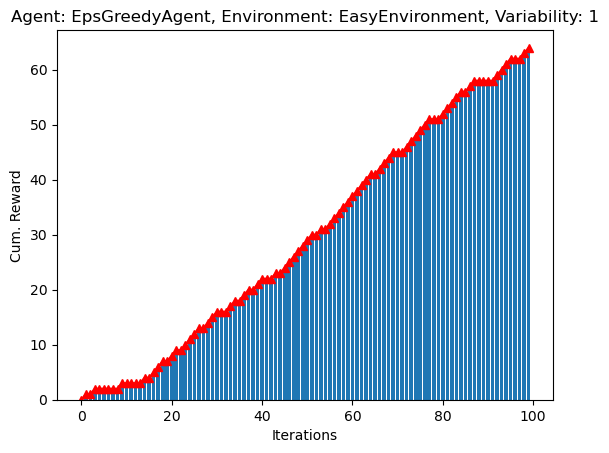

In [176]:
plot_single_run(agent)

We can see in the previous simulation that the algorithm quickly learned to mostly rely on arm 1, which was indeed the best strategy. However, it must not be very hard for this algorithm to fail, if by bad luck a near-optimal arm is chosen at the beginning. Moreover, even after 1M trials, the algorithm will still have a 10% probability of picking a sub-optimal arm, which shouldn't be the case given the vast evidence in favor of the good arm.

### Easy Environment

In [177]:
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

cum_rewards = evaluate_batch(EpsGreedyAgent, environment.EasyEnvironment, ("epsilon", epsilon_values))

EpsGreedyAgent epsilon=0.01 obtained a final average reward of 830.1333333333299
EpsGreedyAgent epsilon=0.05 obtained a final average reward of 850.7999999999938
EpsGreedyAgent epsilon=0.1 obtained a final average reward of 875.1333333333279
EpsGreedyAgent epsilon=0.2 obtained a final average reward of 832.3999999999952
EpsGreedyAgent epsilon=0.3 obtained a final average reward of 721.666666666668
EpsGreedyAgent epsilon=0.5 obtained a final average reward of 684.0666666666691


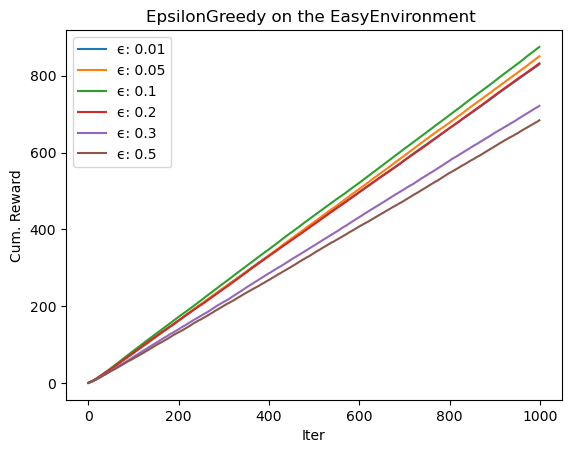

In [178]:
plot_cum_rewards(cum_rewards, ("\u03F5", epsilon_values), "EpsilonGreedy on the EasyEnvironment ")

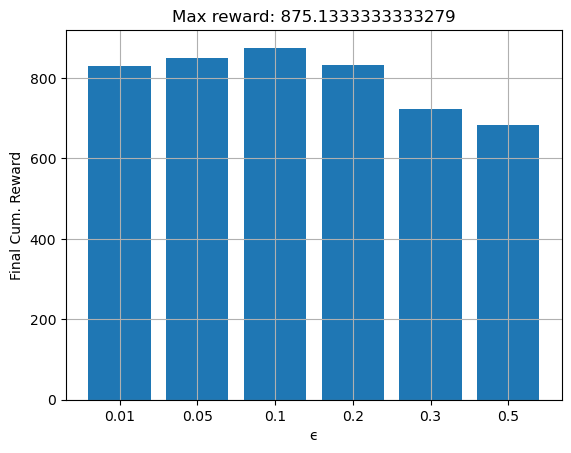

In [179]:
plot_final_rewards(cum_rewards, ("\u03F5", epsilon_values))

### Hard Environment

In [180]:
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

cum_rewards = evaluate_batch(EpsGreedyAgent, environment.HardEnvironment, ("epsilon", epsilon_values))

EpsGreedyAgent epsilon=0.01 obtained a final average reward of 1111.677747900783
EpsGreedyAgent epsilon=0.05 obtained a final average reward of 1316.9836111085322
EpsGreedyAgent epsilon=0.1 obtained a final average reward of 1599.7612798613934
EpsGreedyAgent epsilon=0.2 obtained a final average reward of 1180.064484490226
EpsGreedyAgent epsilon=0.3 obtained a final average reward of 1769.1630989964724
EpsGreedyAgent epsilon=0.5 obtained a final average reward of 1073.1154922799624


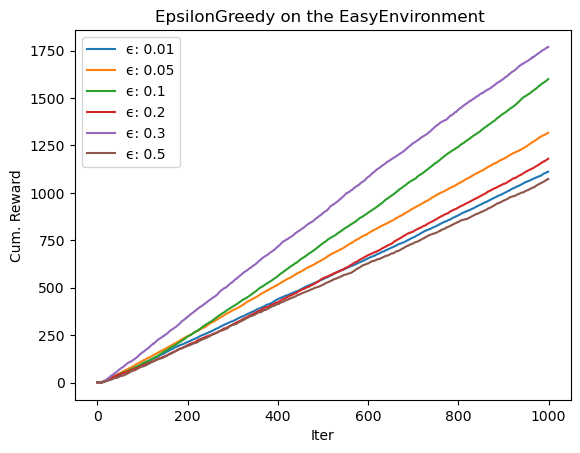

In [181]:
plot_cum_rewards(cum_rewards, ("\u03F5", epsilon_values), "EpsilonGreedy on the EasyEnvironment ")

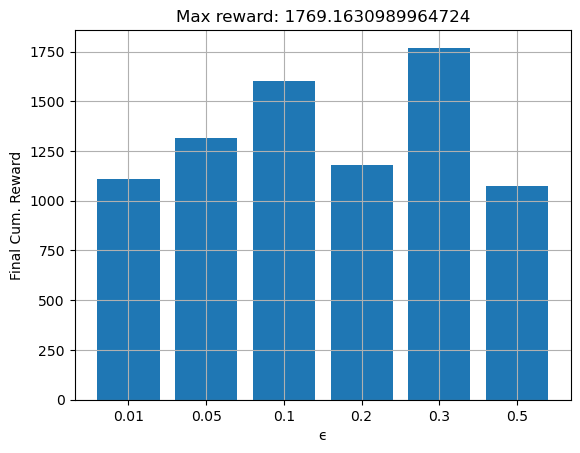

In [183]:
plot_final_rewards(cum_rewards, ("\u03F5", epsilon_values))

For the easy environment it is the lowest values of $\epsilon$ that perform better, which indicates that the distributions of our arms are not very complex, and after a few samples it is reasonable to be more greedy and go for the best performing arm. On the other hand, in the hard environment a higher amount of exploration is needed to really better learn the distributions and make better decisions.

Overall, the EpsilonGreedy agent performs better than the Random agent, as expected. As advantages, I would say that it is easy to understand and interpret. More specifically, it is straighforward to control the exploration/exploitation ratio by modifying a single parameter. The main disadvantage is that this ratio is fixed forever, and it is more reasonable to choose a more exploiting strategy as we gather more information and are more confident about which arm is the good one.

## 2. UCB-1

In [184]:
class UCBAgent:
    # https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf
    def __init__(self, n_actions, ce):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.visited_actions = 0
        self.t = 0
        self.ce = ce

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < len(self.A):
            self.visited_actions += 1
            return self.visited_actions - 1

        self.t += 1
        return np.argmax([np.mean(self.mu[a]) + np.sqrt(self.ce * np.log(self.t) / len(self.mu[a])) for a in self.A])

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.mu[a].append(r)

### Analysis of UCB1

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

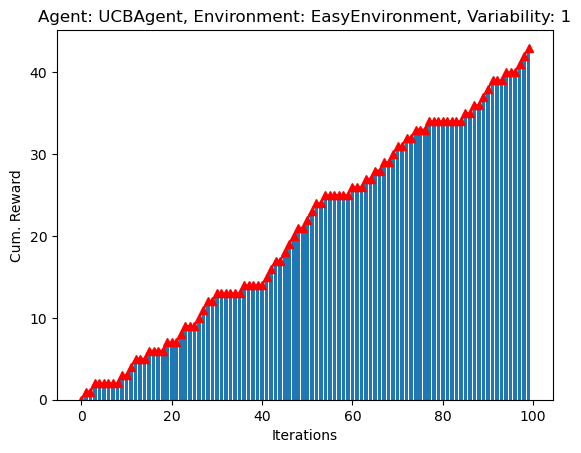

In [186]:
n_actions = 10
agent = UCBAgent(n_actions, 2)
plot_single_run(agent)

In this example the agent performs poorly, mainly because it fails to find the best arm, which is number 1. It continues exploring until the end of the episode, picking arms like 8 and 4 which are clearly inferior.

### Easy Environment

In [187]:
ce_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5, 10]
cum_rewards = evaluate_batch(UCBAgent, environment.EasyEnvironment, ("ce", ce_values))

UCBAgent ce=0.01 obtained a final average reward of 840.799999999995
UCBAgent ce=0.02 obtained a final average reward of 893.8666666666583
UCBAgent ce=0.05 obtained a final average reward of 905.6666666666584
UCBAgent ce=0.1 obtained a final average reward of 882.1999999999919
UCBAgent ce=0.2 obtained a final average reward of 808.9333333333298
UCBAgent ce=0.5 obtained a final average reward of 840.7333333333277
UCBAgent ce=0.8 obtained a final average reward of 780.3333333333302
UCBAgent ce=1 obtained a final average reward of 819.2666666666623
UCBAgent ce=2 obtained a final average reward of 756.4666666666648
UCBAgent ce=5 obtained a final average reward of 706.2000000000007
UCBAgent ce=10 obtained a final average reward of 644.7333333333363


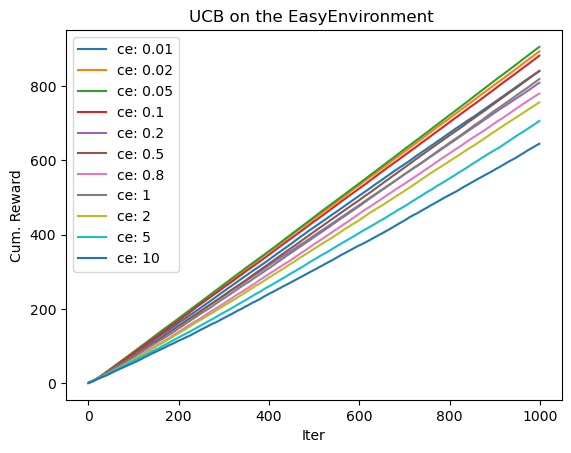

In [189]:
plot_cum_rewards(cum_rewards, ("ce", ce_values), "UCB on the EasyEnvironment ")

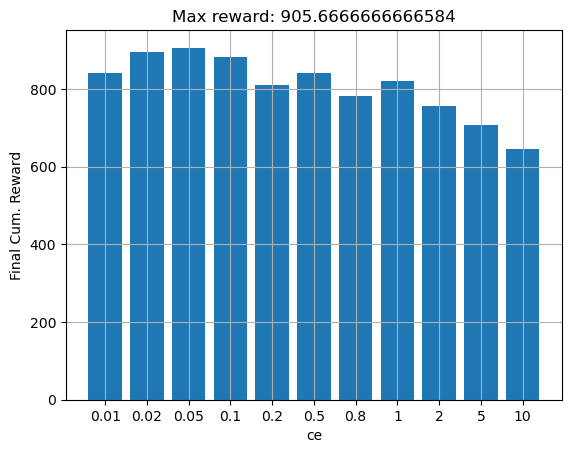

In [190]:
plot_final_rewards(cum_rewards, ("ce", ce_values))

### Hard Environment

In [202]:
ce_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5, 10]
cum_rewards = evaluate_batch(UCBAgent, environment.HardEnvironment, ("ce", ce_values))

UCBAgent ce=0.01 obtained a final average reward of 1155.7941215736273
UCBAgent ce=0.02 obtained a final average reward of 1406.1865090873268
UCBAgent ce=0.05 obtained a final average reward of 1446.8431889558892
UCBAgent ce=0.1 obtained a final average reward of 1212.164307488354
UCBAgent ce=0.2 obtained a final average reward of 2965.8489998068626
UCBAgent ce=0.5 obtained a final average reward of 2383.8379035804664
UCBAgent ce=0.8 obtained a final average reward of 3211.9069461849895
UCBAgent ce=1 obtained a final average reward of 2021.561046564856
UCBAgent ce=2 obtained a final average reward of 1879.145563844886
UCBAgent ce=5 obtained a final average reward of 2159.4829294847655
UCBAgent ce=10 obtained a final average reward of 1961.051234112749


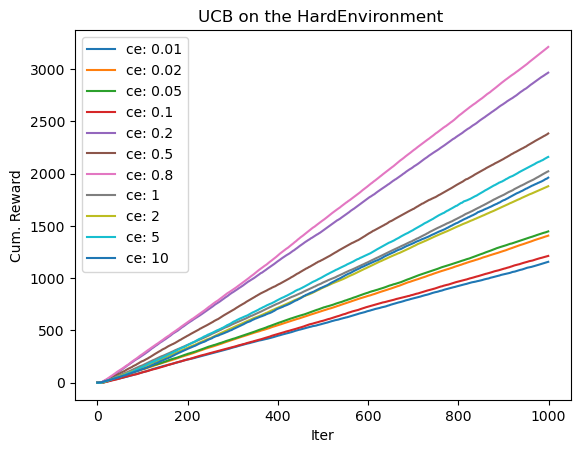

In [203]:
plot_cum_rewards(cum_rewards, ("ce", ce_values), "UCB on the HardEnvironment ")

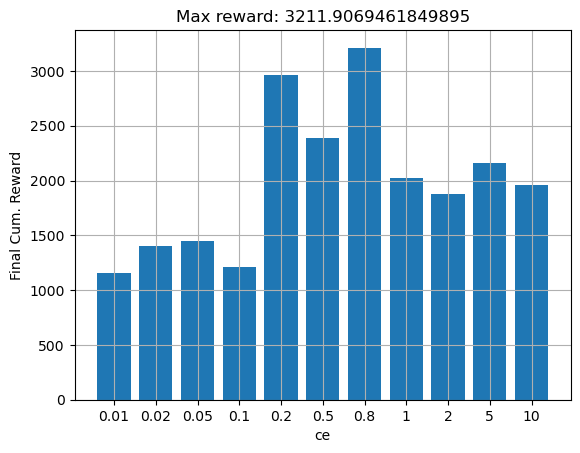

In [204]:
plot_final_rewards(cum_rewards, ("ce", ce_values))

We can see that this agent has a higher performance than EpsilonGreedy, at least for the best performing model with the right value of the hyperparameter $c_e$. This is most likely due the way it handles the exploration/exploitation dilemma. As more steps pass, the arms that are clearly superior are always chosen, and the agent stops making obviously unoptimal choices. As for the main disadvantage, the hyperparameter is difficult to interpret directly, and it seems the model very sensitive to its value, especially for the hard environment.

## 3. Boltzmann Exploration (Softmax) 

In [97]:
class SoftmaxAgent:  # Chose a Temperature between 0.01 and 1
    # https://www.cs.mcgill.ca/~vkules/bandits.pdf
    def __init__(self, n_actions, temperature):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.visited_actions = 0
        self.tau = temperature

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < len(self.A):
            self.visited_actions += 1
            return self.visited_actions - 1

        return np.random.choice(self.A, p=self.softmax())

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.mu[action].append(reward)
    
    def softmax(self):
        mu_vector = np.array([np.mean(self.mu[a]) for a in self.A])
        return np.exp(mu_vector / self.tau) / np.sum(np.exp(mu_vector / self.tau))

### Analysis of Boltzmann Exploration

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

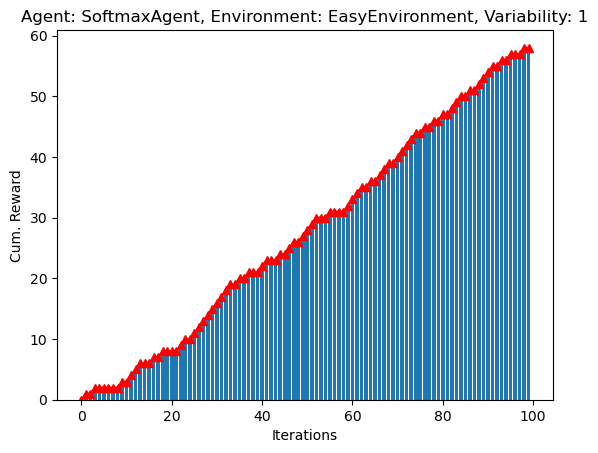

In [196]:
n_actions = 10
agent = SoftmaxAgent(n_actions, 0.1)
plot_single_run(agent)

### Easy Environment

In [205]:
temp_values = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]   
cum_rewards = evaluate_batch(SoftmaxAgent, environment.EasyEnvironment, ("temperature", temp_values))

SoftmaxAgent temperature=0.01 obtained a final average reward of 831.5999999999968
SoftmaxAgent temperature=0.05 obtained a final average reward of 879.8666666666602
SoftmaxAgent temperature=0.1 obtained a final average reward of 887.3999999999925
SoftmaxAgent temperature=0.2 obtained a final average reward of 811.7333333333304
SoftmaxAgent temperature=0.5 obtained a final average reward of 658.7333333333353
SoftmaxAgent temperature=0.8 obtained a final average reward of 583.4666666666695
SoftmaxAgent temperature=1 obtained a final average reward of 582.6000000000031


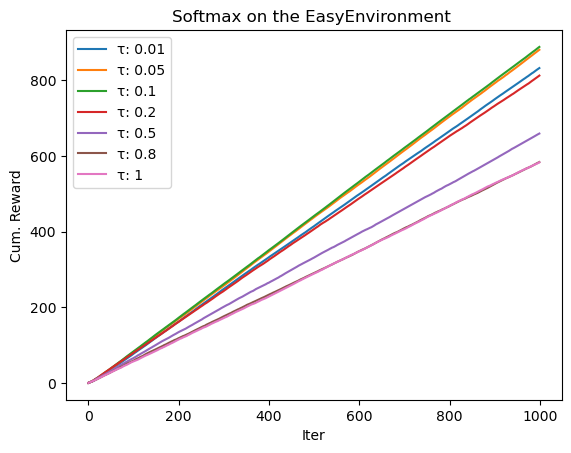

In [206]:
plot_cum_rewards(cum_rewards, ("\u03C4", temp_values), "Softmax on the EasyEnvironment ")

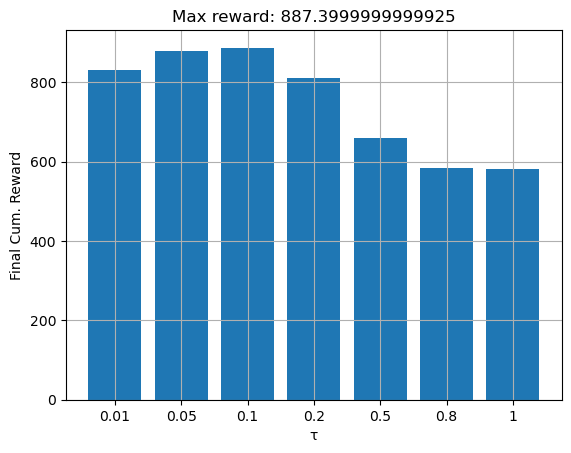

In [207]:
plot_final_rewards(cum_rewards, ("\u03C4", temp_values))

### Hard Environment

In [211]:
temp_values = [0.05, 0.1, 0.2, 0.5, 0.8, 1]   
cum_rewards = evaluate_batch(SoftmaxAgent, environment.HardEnvironment, ("temperature", temp_values))

SoftmaxAgent temperature=0.05 obtained a final average reward of 1171.999200184703
SoftmaxAgent temperature=0.1 obtained a final average reward of 1957.42923186065
SoftmaxAgent temperature=0.2 obtained a final average reward of 2306.629485593373
SoftmaxAgent temperature=0.5 obtained a final average reward of 1204.5398505665846
SoftmaxAgent temperature=0.8 obtained a final average reward of 1596.7136671846772
SoftmaxAgent temperature=1 obtained a final average reward of 2076.677640622956


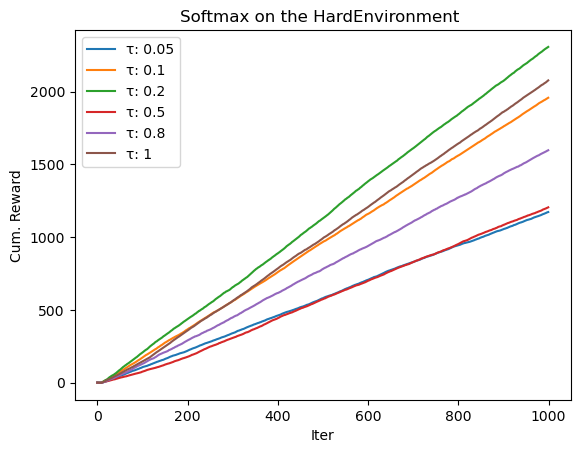

In [212]:
plot_cum_rewards(cum_rewards, ("\u03C4", temp_values), "Softmax on the HardEnvironment ")

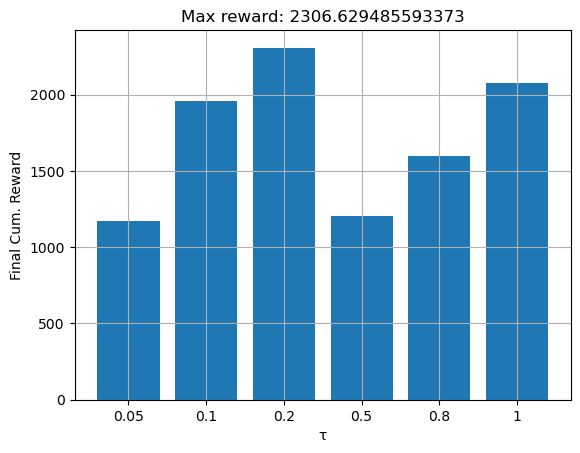

In [213]:
plot_final_rewards(cum_rewards, ("\u03C4", temp_values))

This agent has a more general interpretation of the exploration/exploitation problem. It assigns a higher probability to arms that have a higher expected reward, according to the softmax function and a temperature parameter. The result is that even after many steps have passed, if there is a sub-optimal arms with a close performance to the optimum, it will be selected relatively frequently. This is different from UCB, and it's closer to the EpsilonGreedy agent. Indeed, for a scenario with a particularly high optimal arm and equally bad inferior arms, the probabilities output by the softmax will be equivalent to EpsilonGreedy for some value of $\epsilon$. Therefore, I would list interpretability as the main advantage, and non-adaptive exploration/exploitation trade-off as the main drawback. 

## 4. BESA

In [214]:
class BesaAgent:
    # https://hal.archives-ouvertes.fr/file/index/docid/1025651/filename/BESA2.pdf
    def __init__(self, n_actions):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.visited_actions = 0

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < len(self.A):
            self.visited_actions += 1
            return self.visited_actions - 1

        shuffled_A = np.random.permutation(self.A)
        return self.BESA(shuffled_A)

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.mu[action].append(reward)
    
    def BESA(self, A):
        n = len(A)
        if n == 1:
            return A[0]
        elif n == 2:
            k = min(len(self.mu[A[0]]), len(self.mu[A[1]]))
            A_0 = np.random.choice(self.mu[A[0]], k, replace=False)
            A_1 = np.random.choice(self.mu[A[1]], k, replace=False)
            if np.mean(A_0) > np.mean(A_1):
                return A[0]
            else:
                return A[1]
        else:
            return self.BESA([self.BESA(A[:n//2]), self.BESA(A[n//2:])])

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

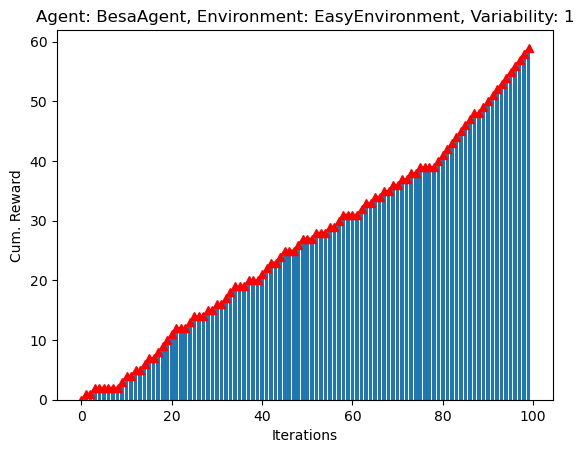

In [216]:
n_actions = 10
agent = BesaAgent(n_actions)
plot_single_run(agent)

### Easy Environment

In [221]:
niter = 1000
n_agents = 10
n_actions = 30

In [222]:
my_runner = runner.BatchRunner(
    environment.EasyEnvironment, BesaAgent, n_agents, n_actions, 1, False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
cum_rewards.append(list_cumul_rd)
print("BaseAgent obtained a final average reward of {}".format(final_reward_rd))

BaseAgent obtained a final average reward of 933.7999999999946


### Hard Environment

In [223]:
my_runner = runner.BatchRunner(
    environment.HardEnvironment, BesaAgent, n_agents, n_actions, 1, False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
cum_rewards.append(list_cumul_rd)
print("BaseAgent obtained a final average reward of {}".format(final_reward_rd))

BaseAgent obtained a final average reward of 3200.913528267046


### Analysis of BESA

I find this algorithm very clever and intuitive. In order to determine which action to take, it organizes a tournament between all the possible actions, and the winner gets chosen. When actions that have been chosen a different number of times compete, the one with more samples has to sub-sample its rewards to match the oponent's. Moreover, the algorithm also shuffles the order of the actions at every step so that actions have the same chances to face the other at every stage of the tournament. Some advantages of this algorithm are: easy to interpret, no hyperparameter tuning, effective to balance exploration/exploitation, with an organic way to decrease exploration as more steps pass. The main disadvantage is that it's computationally expensive, as we have to shuffle the actions, sample the rewards, and simulate the tournament for each step.

## 5. KL-UCB

In [231]:
class KLUCBAgent:
    # See: https://hal.archives-ouvertes.fr/hal-00738209v2
    def __init__(self, n_actions, verbose=False, factor=3):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.visited_actions = 0
        self.t = 0
        self.verbose = verbose
        self.upper_bounds = None
        self.factor = factor 

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < len(self.A):
            self.visited_actions += 1
            self.t += 1
            return self.visited_actions - 1

        self.t += 1
        if self.upper_bounds is None:
            self.upper_bounds = np.array([self.upper_bound(a) for a in self.A])

        max_ix = np.where(self.upper_bounds == np.max(self.upper_bounds))[0]
        if self.verbose:
            print(self.upper_bounds, max_ix)
        return np.random.choice(max_ix)
    
    def upper_bound(self, a):
        mean = np.mean(self.mu[a])
        if mean == 1:
            return 1

        def f(q):
            return self.kl_divergence(mean, q) - (np.log(self.t) + self.factor*np.log(np.log(self.t)))/len(self.mu[a])
        
        if f(1) < 0:
            return 1
        
        solution = root_scalar(f, bracket=[mean, 1]).root
        return solution
    
    @staticmethod
    def kl_divergence(p, q):
        eps = 1e-15
        q = np.clip(q, eps, 1 - eps)
        if p == 0:
            return (1 - p) * np.log((1 - p) / (1 - q))
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.mu[a].append(r)
        if self.upper_bounds is not None:
            self.upper_bounds[a] = self.upper_bound(a)

### Analysis of KL-UCB

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

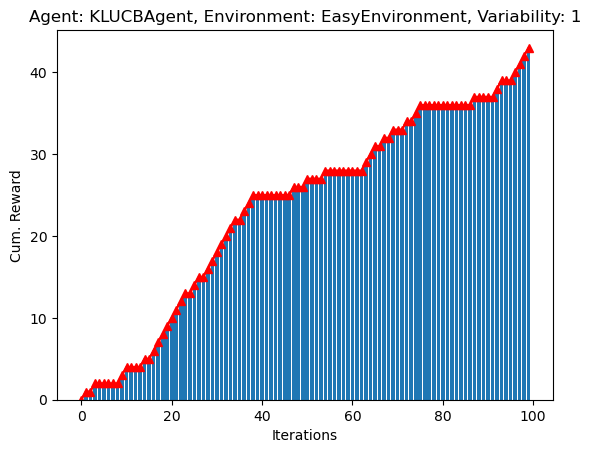

In [232]:
n_actions = 10
agent = KLUCBAgent(n_actions, verbose=True, factor=3)
plot_single_run(agent)

### Easy Environment

In [228]:
factor_values = [0.1, 0.5, 1, 2, 3, 10]
cum_rewards = evaluate_batch(KLUCBAgent, environment.EasyEnvironment, ('factor', factor_values))

KLUCBAgent factor=0.1 obtained a final average reward of 830.7999999999961
KLUCBAgent factor=0.5 obtained a final average reward of 869.8666666666601
KLUCBAgent factor=1 obtained a final average reward of 815.1999999999962
KLUCBAgent factor=2 obtained a final average reward of 836.733333333329
KLUCBAgent factor=3 obtained a final average reward of 818.3333333333288
KLUCBAgent factor=10 obtained a final average reward of 827.0666666666625


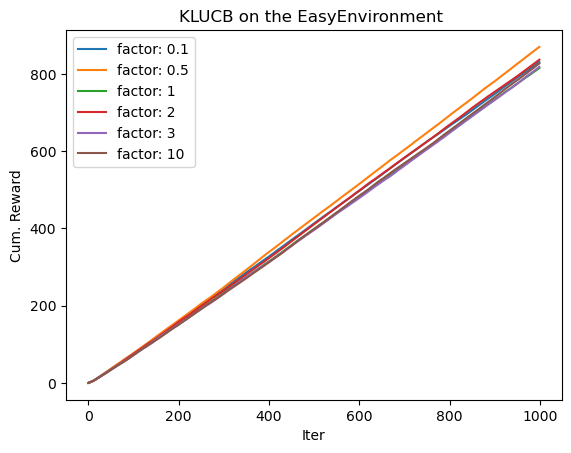

In [229]:
plot_cum_rewards(cum_rewards, ('factor', factor_values), "KLUCB on the EasyEnvironment ")

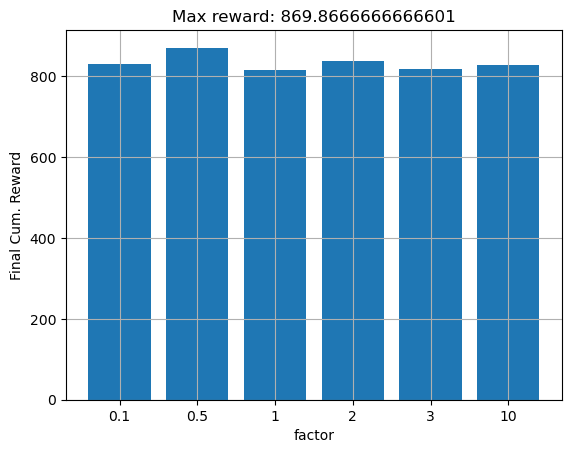

In [233]:
plot_final_rewards(cum_rewards, ('factor', factor_values))

### Hard Environment: 

This one is more difficult because we have other parameters to be estimated and optimized over. According to my intuition, we would need to define a way to get a probability distribution from the empirical statistics and be able to compute the KL-divergence with it and a general form of the distribution. Then it would be a matter of optimizing it subject to the upperbound. 


This agent follows the same intuition as the normal UCB one, choosing the arm based on an optimistic perspective, which means selecting the arm with the highest upper bound. This means that arms highly variable, or for which we don't have enough samples, will be selected more often as we hope that it reveals to be a good option. The key difference is that the way we estimate the upper bound is quite different, relying on the Kullback-Leiber divergence. The inner workings of the algorithm are difficult to understand mathematically, but with the formulas they are straightforward to implement. Nonetheless, it does not offer a very high reward compared to other algorithms such as BESA.

## 6. Thompson Sampling

> Try first to implement the Bernoulli Bandit Thompson Sampling algorithm on the ```EasyEnvironment```. https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf
Additional points will be granted for a Thompson Agent on the ```HardEnvironment```

In [238]:
from scipy.stats import beta as beta_sts

In [240]:
class ThompsonAgent:
    # https://en.wikipedia.org/wiki/Thompson_sampling
    def __init__(self, n_actions):
        self.A = range(n_actions)
        self.mu = {a: {'a':1, 'b':1} for a in self.A}
        self.visited_actions = 0

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        if self.visited_actions < len(self.A):
            self.visited_actions += 1
            return self.visited_actions - 1

        sampled_ps = [self.sample_beta(a) for a in self.A]
        return np.argmax(sampled_ps)

    def sample_beta(self, a):
        alpha = self.mu[a]['a']
        beta = self.mu[a]['b']

        return beta_sts.rvs(alpha, beta)

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        if r == 1:
            self.mu[a]['a'] += 1
        else:
            self.mu[a]['b'] += 1

### Analysis of Thompson Sampling

0.417022004702574
0.7203244934421581
0.00011437481734488664
0.30233257263183977
0.14675589081711304
0.0923385947687978
0.1862602113776709
0.34556072704304774
0.39676747423066994
0.538816734003357
Simulation step 1:
 ->            action: 0
 ->            reward: 0
 -> cumulative reward: 0.0
Simulation step 2:
 ->            action: 1
 ->            reward: 1
 -> cumulative reward: 1.0
Simulation step 3:
 ->            action: 2
 ->            reward: 0
 -> cumulative reward: 1.0
Simulation step 4:
 ->            action: 3
 ->            reward: 1
 -> cumulative reward: 2.0
Simulation step 5:
 ->            action: 4
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 6:
 ->            action: 5
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 7:
 ->            action: 6
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 8:
 ->            action: 7
 ->            reward: 0
 -> cumulative reward: 2.0
Simulation step 9:
 ->            ac

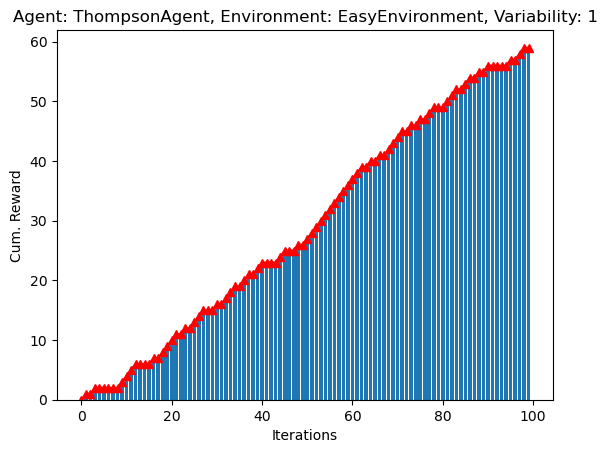

In [245]:
n_actions = 10
agent = ThompsonAgent(n_actions)
plot_single_run(agent)

In [242]:
niter = 1000
n_agents = 10
n_actions = 30

### Easy Environment

In [244]:
my_runner = runner.BatchRunner(
    environment.EasyEnvironment, ThompsonAgent, n_agents, n_actions, 1, False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
cum_rewards.append(list_cumul_rd)
print("ThompsonAgent obtained a final average reward of {}".format(final_reward_rd))

ThompsonAgent obtained a final average reward of 884.6999999999931


### Hard Environment

Using the ThompsonSampling in this environment is much more difficult than doing it in the easy one. As we have other parameters (offset and scale) that change the distribution of rewards that we get for each arm. Based on my intuition on the workings of the algorithm, we would need to model these parameters with a prior distribution and update it accordingly based on the seen rewards.

This agent follows a Bayesian perspective on the estimation of the distribution parameters for the arms' rewards. It assumes a $\beta$ prior and updates its parameters based on the seen rewards. The parameters of the distribution coincide with the number of failures and successes of that arm, so they are easy to interpret and update. When it is time to choose arm, it samples from these distributions and picks the one with the highest sample. As the distributions get narrower around the empirical mean, it is less likely to pick under-optimal arms, but there will always be a chance. This is different from the UCB algorithm, so we expect more exploratory behavior even in late stages of the episodes. 